In [6]:
from src.datasetSetup import srediDataset
srediDataset("datasetovi", "dataset1.zip")

Skidanje dataseta, unzipovanje, organizovanje (iznad) 

Loading data i ucitavanje pretreniranog modela, detektovanje objekata na slici PRE fine-tuninga

c:\Users\Andjela\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andjela\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Label index 37 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  9, 37,  1, 84,  1, 43,  1, 72, 43, 10,  8,  1, 76,
        43, 38,  1, 76,  1, 43, 43,  1, 62, 73,  1,  1, 73,  1,  1, 62,  1, 43,
         1,  1,  1, 43])
Classes length: 21
Label index 84 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  9, 37,  1, 84,  1, 43,  1, 72, 43, 10,  8,  1, 76,
        43, 38,  1, 76,  1, 43, 43,  1, 62, 73,  1,  1, 73,  1,  1, 62,  1, 43,
         1,  1,  1, 43])
Classes length: 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


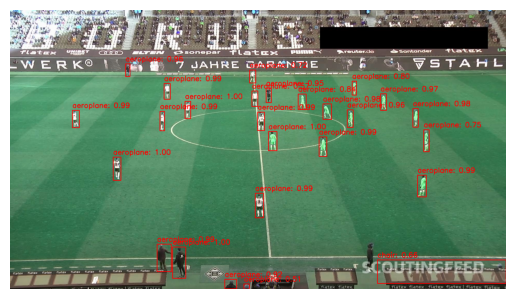

Label index 37 out of range for CLASSES list.
Labels: tensor([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1, 37,  8,  1, 16,  1, 43,  1,  1,  1, 76, 84,  1,
         1,  9, 73,  1, 15, 33,  1, 72])
Classes length: 21


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


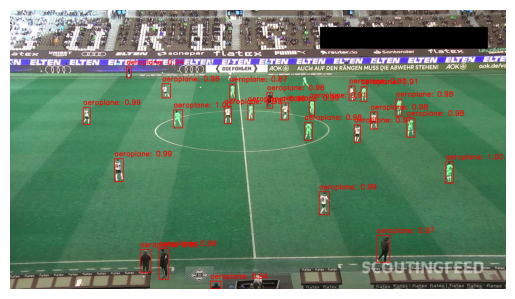

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


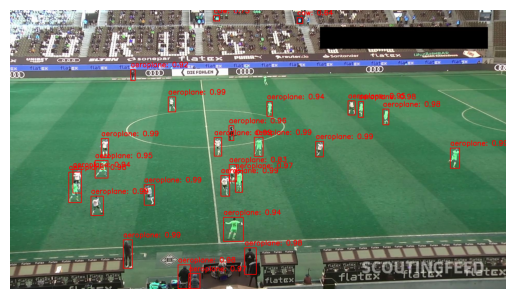

KeyboardInterrupt: 

In [2]:
import matplotlib.pyplot as plt
import torchvision
import cv2
from src.customDataset import CustomVOCDataset
from src.modelFunkcije import *

# Definisemo Pascal VOC klase
classes = [
    '__background__',  # index 0
    'aeroplane', 'bicycle', 'bird', 'boat',
    'bottle', 'bus', 'car', 'cat', 'chair',
    'cow', 'diningtable', 'dog', 'horse',
    'motorbike', 'person', 'pottedplant',
    'sheep', 'sofa', 'train', 'tvmonitor'
]

# Definisemo transformations
transform = T.Compose([T.ToTensor()])

# Kreiramo dataset instancu i dataloader
dataset = CustomVOCDataset(root='datasetovi/dataset1.zip_sredjen/valid', CLASSES=classes, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)

# Ucitamo pretrenirani Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Pokrenemo detektovanje nad datasetom koji smo load-ovali
for images, targets in data_loader:
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        prediction = model(images)

    for img, pred in zip(images, prediction):
        plot_image_with_boxes(img, pred['boxes'], pred['labels'], pred['scores'], classes)

Loading data i fine-tuning modela

In [2]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from src.customDataset import CustomVOCDataset
from src.modelFunkcije import *

# Definisemo klase za detekciju
CUSTOM_CLASSES = ['__background__', 'player', 'referee', 'goalkeeper', 'ball']

# Definisemo transformations
transform = T.Compose([T.ToTensor()])

def my_collate_fn(x): return tuple(zip(*x))

# Kreiramo dataset instancu i dataloader
dataset = CustomVOCDataset(root='datasetovi/dataset1.zip_sredjen/test', CLASSES=CUSTOM_CLASSES, transforms=transform)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=my_collate_fn)

# Glavni deo koda za trening
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = len(CUSTOM_CLASSES)
model = get_model(num_classes)
model.to(device)

num_epochs = 10
train_model(model, data_loader, device, num_epochs)

# Cuva model
torch.save(model.state_dict(), 'frcnn_custom.pth')



PicklingError: Can't pickle <function <lambda> at 0x000002309DA05940>: attribute lookup <lambda> on __main__ failed

In [5]:
import cv2
import matplotlib
import matplotlib.pyplot as plt

model.eval()
# Pokrenemo detektovanje nad datasetom koji smo load-ovali
for images, targets in data_loader:
    images = list(img.to(device) for img in images)

    with torch.no_grad():
        prediction = model(images)

    for img, pred in zip(images, prediction):
        plot_image_with_boxes(img, pred['boxes'], pred['labels'], pred['scores'], CUSTOM_CLASSES)

PicklingError: Can't pickle <function <lambda> at 0x00000258872A56C0>: attribute lookup <lambda> on __main__ failed